In [1]:
from models.model_v3 import *
from utils.dataset_loader import *
from utils.testing_model import *
import pretty_midi
import copy

pygame 2.6.1 (SDL 2.28.4, Python 3.12.0)
Hello from the pygame community. https://www.pygame.org/contribute.html


## Setup

In [2]:
# Define the dataset.
DATA_FILE_PATH = "data/preprocessed/maestro-v3.0.0/dataset3/50k_augmented_1.h5"
dataset = MaestroV3DataSet(DATA_FILE_PATH, "triplet")

# Load model from checkpoint.
ckp_path = "./outputs/checkpoints/model_v3/50k_augmented_1/checkpoint_epoch=19.ckpt"
model = GAN.load_from_checkpoint(ckp_path)

In [3]:
# Major chords first notes (starts from C = 1th note)
MAJOR_CHORDS = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
# Minor chords first notes (starts from A = 10th note)
MINOR_CHORDS = [9, 10, 11, 0, 1, 2, 3, 4, 5, 6, 7, 8]


MAJOR_CHORD_NOTE_TRIPLETS = [
    [0, 4, 7],    # C Major (Tonic 0)
    [1, 5, 8],    # C# Major (Tonic 1)
    [2, 6, 9],    # D Major (Tonic 2)
    [3, 7, 10],   # D# Major (Tonic 3)
    [4, 8, 11],   # E Major (Tonic 4)
    [5, 9, 0],    # F Major (Tonic 5)
    [6, 10, 1],   # F# Major (Tonic 6)
    [7, 11, 2],   # G Major (Tonic 7)
    [8, 0, 3],    # G# Major (Tonic 8)
    [9, 1, 4],    # A Major (Tonic 9)
    [10, 2, 5],   # A# Major (Tonic 10)
    [11, 3, 6]    # B Major (Tonic 11)
]

MINOR_CHORD_NOTE_TRIPLETS = [
    [9, 0, 4],    # A Minor (Tonic 9)
    [10, 1, 5],   # A# Minor (Tonic 10)
    [11, 2, 6],   # B Minor (Tonic 11)
    [0, 3, 7],    # C Minor (Tonic 0)
    [1, 4, 8],    # C# Minor (Tonic 1)
    [2, 5, 9],    # D Minor (Tonic 2)
    [3, 6, 10],   # D# Minor (Tonic 3)
    [4, 7, 11],   # E Minor (Tonic 4)
    [5, 8, 0],    # F Minor (Tonic 5)
    [6, 9, 1],    # F# Minor (Tonic 6)
    [7, 10, 2],   # G Minor (Tonic 7)
    [8, 11, 3]    # G# Minor (Tonic 8)
]


In [4]:
# n chord of a specific ocatve, setted with the offset
def pattern_1(bars, selected_chord , offset, n_bars):
    for elem,b in enumerate(bars):
                    #print(b.shape[2] - 1 - offset - 12)
                    #print(b.shape[2] - 1 - offset) 
                    if elem < n_bars:
                        # Row minor (needed to iterate in the correct block of a single bar (elem))
                        for i in range(offset, 12 + offset, 1):
                            for j in range(b.shape[3] - 1):
                                #print(i)
                                #print(selected_chord[0],selected_chord[1], selected_chord[2])
                                if i == selected_chord[0] + offset or i == selected_chord[1] + offset or i == selected_chord[2] + offset:
                                    b[0,0,i,j] = 0.7

In [5]:
# n chords of an octave and len(bars) - n chords of an octave below
def pattern_2(bars, selected_chord , offset, n_bars):
    for elem,b in enumerate(bars):
                    if elem < n_bars:
                        # Row minor.
                        for i in range(offset, 12 + offset, 1):
                            for j in range(b.shape[3] - 1):
                                # Activation of the chord.
                                if i == selected_chord[0] + offset or i == selected_chord[1] + offset or i == selected_chord[2] + offset:
                                    b[0,0,i,j] = 0.7
                  
                    if elem <= len(bars) and elem >= n_bars:
                        for i in range(offset, 12 + offset, 1):
                            for j in range(b.shape[3] - 1):
                                # Activation of the chord .
                                if i == selected_chord[0] + offset or i == selected_chord[1] + offset or i == selected_chord[2] + offset :
                                    b[0,0,i - 12,j] = 0.7
                          

In [6]:
# n chords of an octave and len(bars) - n chords of an octave below (Alternate pattern)
def pattern_3(bars, selected_chord , offset):
    for elem,b in enumerate(bars):
                    if elem <= len(bars) and elem%2 == 0 :
                        # Row minor.
                        for i in range(offset, 12 + offset, 1):
                            for j in range(b.shape[3] - 1):
                                # Activation of the chord.
                                if i == selected_chord[0] + offset or i == selected_chord[1] + offset or i == selected_chord[2] + offset:
                                    b[0,0,i,j] = 0.7

                    if elem <= len(bars) and elem%2 == 1:
                        for i in range(offset, 12 + offset, 1):
                            for j in range(b.shape[3] - 1):
                                # Activation of the chord .
                                if i == selected_chord[0] + offset or i == selected_chord[1] + offset or i == selected_chord[2] + offset :
                                    b[0,0,i - 12,j] = 0.7
                                    

In [7]:
# Make the chord press for tunable number of steps and silence steps for 3 time in a bar.
# directly in this function is possible to tune these pars.
def pattern_4(bars, selected_chord, offset, n_bars):
    
    for elem, b in enumerate(bars):
        if elem % n_bars == 0:
            time_idx = 0
            while time_idx < b.shape[3]:
                
                # Chord for 4 time step (tunable).
                for _ in range(4):
                    if time_idx < b.shape[3]:
                        for note_offset in selected_chord:
                            note_pitch = note_offset + offset
                            if 0 <= note_pitch < b.shape[2]:
                                b[0, 0, note_pitch, time_idx] = 0.7
                        time_idx += 1
                    else:
                        break

                # Pause for 3 time steps (tunable).
                time_idx += 3

                # Chord for 2 time step (tunable).
                for _ in range(2):
                    if time_idx < b.shape[3]:
                        for note_offset in selected_chord:
                            note_pitch = note_offset + offset
                            if 0 <= note_pitch < b.shape[2]:
                                b[0, 0, note_pitch, time_idx] = 0.7
                        time_idx += 1
                    else:
                        break

                # Pause for 1 time step (tunable).
                time_idx += 1

                # Chord until the end of the bar.
                while time_idx < b.shape[3]:
                    for note_offset in selected_chord:
                        note_pitch = note_offset + offset
                        if 0 <= note_pitch < b.shape[2]:
                            b[0, 0, note_pitch, time_idx] = 0.7
                    time_idx += 1

In [8]:
# Equal to pattern 4 but similary to pattern 3 alternates every bar with a different octave
def pattern_5(bars, selected_chord, offset):
    for elem, b in enumerate(bars):
        current_offset = offset
        if elem % 2 != 0:  
            current_offset = offset - 12 

        time_idx = 0
        while time_idx < b.shape[3]:
            # Chord for 4 time step (tunable).
            for _ in range(4):
                if time_idx < b.shape[3]:
                    for note_offset in selected_chord:
                        note_pitch = note_offset + current_offset
                        if 0 <= note_pitch < b.shape[2]:
                            b[0, 0, note_pitch, time_idx] = 0.7
                    time_idx += 1
                else:
                    break

            # Pause for 3 time steps (tunable).
            time_idx += 3

            # Chord for 2 time step (tunable).
            for _ in range(2):
                if time_idx < b.shape[3]:
                    for note_offset in selected_chord:
                        note_pitch = note_offset + current_offset
                        if 0 <= note_pitch < b.shape[2]:
                            b[0, 0, note_pitch, time_idx] = 0.7
                    time_idx += 1
                else:
                    break

            # Pause for 1 time steps (tunable).
            time_idx += 1

            
            # Chord until the end of the bar.
            while time_idx < b.shape[3]:
                for note_offset in selected_chord:
                    note_pitch = note_offset + current_offset
                    if 0 <= note_pitch < b.shape[2]:
                        b[0, 0, note_pitch, time_idx] = 0.7
                time_idx += 1

In [9]:
# Function to insert a Basic pattern chords, chosing the one with the param choice 
def pattern_chords(bars, selected_chord, choice = 1, offset = 4, n_bars = 4):
     print("ciao")
     match choice:
          case 1:
               print("selected 1")
               return pattern_1(bars, selected_chord, offset, n_bars)
          case 2:
               print("selected 2")
               return pattern_2(bars, selected_chord, offset, n_bars)
          case 3:
               print("selected 3")
               return pattern_3(bars, selected_chord, offset)
          case 4: 
               print("selected 4")
               return pattern_4(bars, selected_chord, offset, n_bars) 
          case 5:
               print("selected 5")
               return pattern_5(bars, selected_chord, offset) 
    
    


In [10]:
# Function to decoding the chords emmbedded in the output tensor generated by the network
def decoding_chord(bars, chord_0, pattern_choice, offset = 4, n_bars = 4):
    index = -1
     # Major chord
    if chord_0[0,12,0,0] == 0:
        print("Major chords")
        encoded_chord = np.where(chord_0 == 1)

        if encoded_chord[0].size > 0:
            index = encoded_chord[1][0]
        
        selected_chord = MAJOR_CHORD_NOTE_TRIPLETS[index]
        # To select the octave of the chord
        offset = 4
        offset = offset * 12
        
        pattern_chords(bars, selected_chord, pattern_choice, offset, n_bars)

    # Minor chord
    elif chord_0[0,12,0,0] == 1:
        print("Minors chords")
        encoded_chord = np.where(chord_0 == 1)

        if encoded_chord[0].size > 0:
            index = encoded_chord[1][0]
        
        selected_chord = MINOR_CHORD_NOTE_TRIPLETS[index]
        # To select the octave of the chord
        #offset = 4
        offset = offset * 12

        pattern_chords(bars,selected_chord, pattern_choice, offset, n_bars)
    
    

In [11]:
 # Convert bars in numpy array.
def bars_to_piano_roll(bars, verbose):
    # Convert bars in numpy array.
    bars_numpy = []
    for bar in bars:
        bar = bar.squeeze(0, 1).detach().numpy()
        bars_numpy.append(bar)

    # Create the full piano roll.
    full_piano_roll = np.hstack([bar for bar in bars_numpy])
    if verbose:
        print("Full piano roll")
        print("Shape:", full_piano_roll.shape)
        show_piano_roll(full_piano_roll)

    # Multiply by 50.
    full_piano_roll *= 50

    # Create midi file.
    pm = piano_roll_to_pretty_midi(full_piano_roll, fs=8)
    return pm

In [12]:

# Generate a melody that in future processing can be accompanied with chords
def generate_melody_v3(model, n_bars, dataset, verbose=False):
# Set model in evaluation.
    model.eval()
    model = model.cpu()

    # Generate noise.
    noise = torch.randn(7, 1, 100)

    # Random index.
    rnd_idx = random.randint(0, len(dataset)-1)

    # Choose the first random sample from the dataset.
    bar_0, _ , _ = dataset[rnd_idx] # [1, 128, 16]
    bar_0 = bar_0.unsqueeze(0)  # [1, 1, 128, 16]

    _ , _ , chord_0 = dataset[rnd_idx] # [13 , 1, 1]
    chord_0 = chord_0.unsqueeze(0) # [1, 13 , 1 , 1] 

    # Generate 8 bar.
    bars = [bar_0]
    for i , z in enumerate(noise):
        # Previous bar.
        prev = bars[i]

        # Create the triplet.
        x = z, prev, chord_0

        # Generate current bar.
        curr = model(x)

        # Save genjerated bar
        bars.append(curr)

    # Processing to add in a specific way the coding of the chord for each bar
    #chord_0 = torch.zeros((1,13,1,1), dtype=int)
    #chord_0[0,1,0,0] = 1

    pm = bars_to_piano_roll(bars,verbose)

    return pm, bars, chord_0

    # for i in range(b.shape[2] - 1 - offset, b.shape[2] - 1 - offset - 12, -1):
    #     for j in range(b.shape[3] - 1 - 8):
    #         print(i)
    #         print(selected_chord[0],selected_chord[1], selected_chord[2])
    #         if i - comparison_offset == selected_chord[0] or i - comparison_offset == selected_chord[1] or i - comparison_offset == selected_chord[2]:
    #             
    #             b[0,0,i,j] = 0.6


## Generate melody

Full piano roll
Shape: (128, 128)


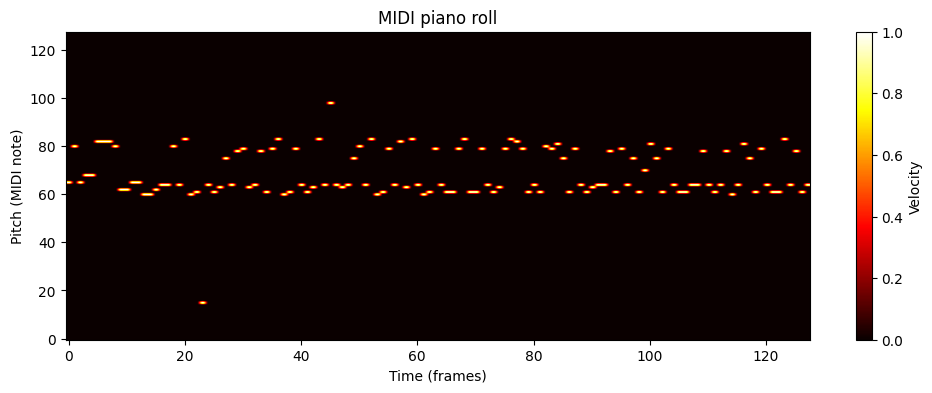

In [13]:
melody_pm_tryal, bars, chord_0 = generate_melody_v3(model, n_bars=8, dataset=dataset, verbose=True)


## Play generated melody with pygame

In [14]:
# Create the output midi file.
output_fn = "output_test.midi"
melody_pm_tryal.write(output_fn)

In [15]:
#reproduce_midi("output_test.midi")

## Choosing The chord pattern accompaniment based on chord_0


In [16]:
# we need to detach from the computational graph
bars = [bar.detach() for bar in bars]

bars_copy_1 = copy.deepcopy(bars)
bars_copy_2 = copy.deepcopy(bars)
bars_copy_3 = copy.deepcopy(bars) 
bars_copy_4 = copy.deepcopy(bars) 
bars_copy_5 = copy.deepcopy(bars) 

#bars_copy = copy.deepcopy(bars)  


Major chords
ciao
selected 1
Full piano roll
Shape: (128, 128)


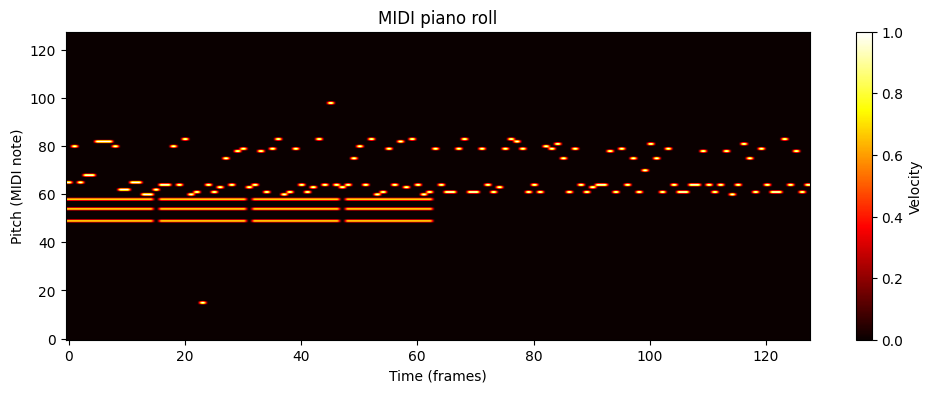

Major chords
ciao
selected 2
Full piano roll
Shape: (128, 128)


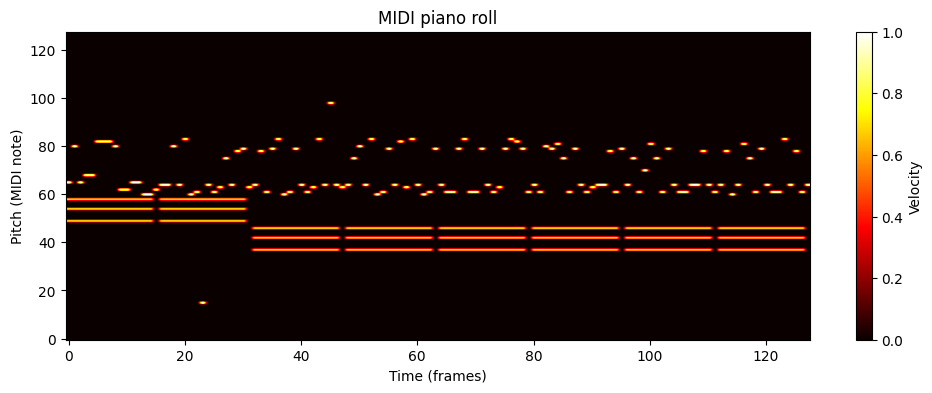

Major chords
ciao
selected 3
Full piano roll
Shape: (128, 128)


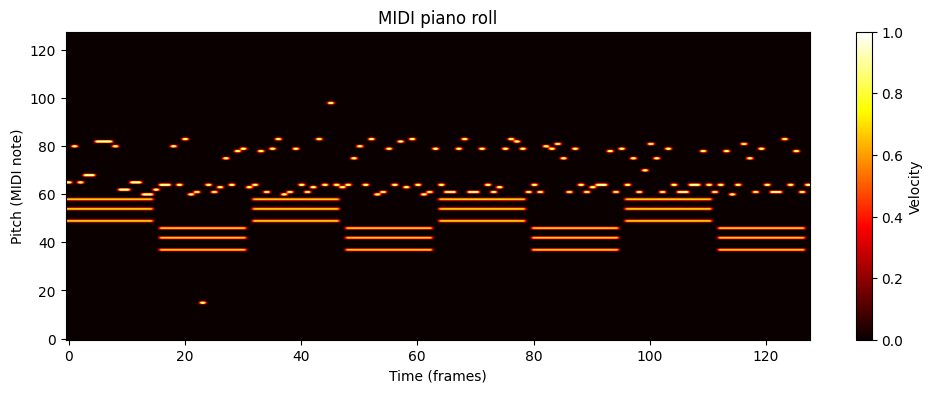

Major chords
ciao
selected 4
Full piano roll
Shape: (128, 128)


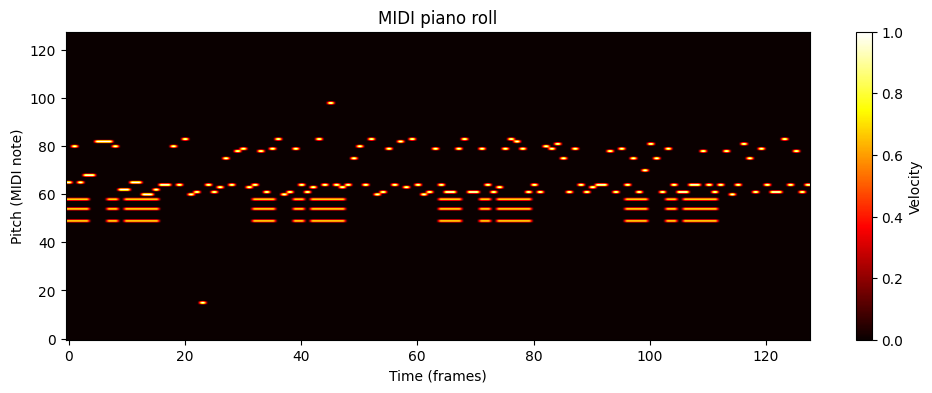

Major chords
ciao
selected 5
Full piano roll
Shape: (128, 128)


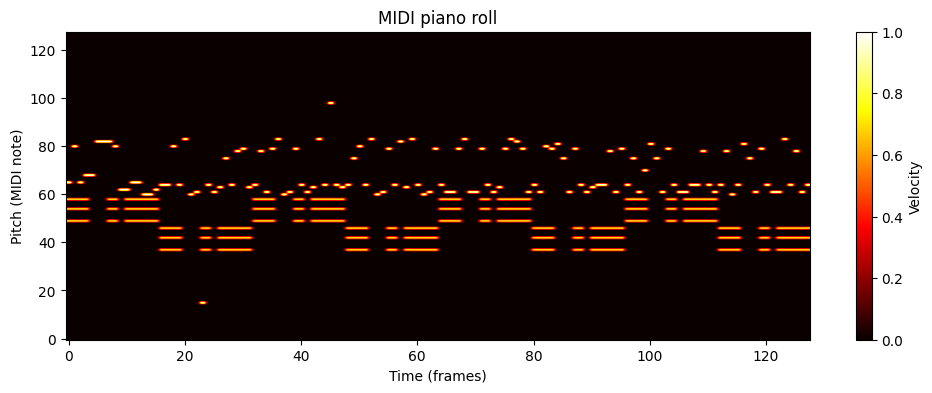

In [17]:
# to decoding_chord pass bars, chord_0, num of choosen pattern, offset (aka number of the octave), n_bars, 
decoding_chord(bars_copy_1, chord_0, 1, 4, 4)
melody_pm_1 = bars_to_piano_roll(bars_copy_1, True)

decoding_chord(bars_copy_2, chord_0, 2, 4, 2)
melody_pm_2 = bars_to_piano_roll(bars_copy_2, True)


decoding_chord(bars_copy_3, chord_0, 3, 3)
melody_pm_3 = bars_to_piano_roll(bars_copy_3, True) 

decoding_chord(bars_copy_4, chord_0, 4, 4, 2)
melody_pm_4 = bars_to_piano_roll(bars_copy_4, True) 

decoding_chord(bars_copy_5, chord_0, 5, 2)
melody_pm_5 = bars_to_piano_roll(bars_copy_5, True) 


# Create the output midi file.
output_fn_1 = "output_test_1.midi"
melody_pm_1.write(output_fn_1)

output_fn_2 = "output_test_2.midi"
melody_pm_2.write(output_fn_2)

output_fn_3 = "output_test_3.midi"
melody_pm_3.write(output_fn_3)

output_fn_4 = "output_test_4.midi"
melody_pm_4.write(output_fn_4)

output_fn_5 = "output_test_5.midi"
melody_pm_5.write(output_fn_5)



In [18]:
#reproduce_midi("output_test_1.midi")

In [19]:
#reproduce_midi("output_test_2.midi")

In [20]:
#reproduce_midi("output_test_3.midi")

In [21]:
reproduce_midi("output_test_4.midi")

🎵 Reproduction of'output_test_4.midi'...
Reproduction ended.


In [22]:
reproduce_midi("output_test_5.midi")

🎵 Reproduction of'output_test_5.midi'...
Reproduction ended.


In [23]:
v#import numpy as np
#from pypianoroll import Multitrack, Track 
#import pypianoroll as pypiano
#import torch
#import matplotlib
#matplotlib.use('Agg')
#import matplotlib.pyplot as plt
#import ipdb
#
#
#
#def find_pitch(song,volume=40):   # song shape(128,128), which is (time step, pitch)
#    for time in range(song.shape[0]):
#        step = song[time,:]
#        max_index = np.argmax(step)
#        for i in range(len(step)):
#            if i ==max_index:
#                song[time,i] = volume
#            else:
#                song[time,i] = 0
#    return song
#
#def reshape_bar(song):
#    eight_bar = song[0]
#    for i in range(7):
#        b = song[i+1]
#        eight_bar  = np.concatenate((eight_bar,b),axis=0)
#    eight_bar = eight_bar.astype(float)
#    print("A bar's shape: {}".format(eight_bar.shape))
#    return eight_bar
#
#def make_a_track(eight_bar_binarized,track_name ='melody' ,instrument=0):
#    track = Track(pianoroll=eight_bar_binarized, program=instrument, is_drum=False,name=track_name)
#    return track
#
#def make_a_demo(track1,track2,song_idx):
#    sample_name = 'sample_'+str(song_idx)
#
#    multitrack = Multitrack(tracks=[track1,track2], tempo=120.0,beat_resolution=4)
#    
#    pypiano.plot(multitrack, filepath='your file situation', mode='separate', preset='default', cmaps=None, xtick='auto', ytick='octave', xticklabel=True, yticklabel='auto', tick_loc=None, tick_direction='in', label='both', grid='both', grid_linestyle=':', grid_linewidth=0.5)
#    plt.savefig('your file situation'+sample_name+'.png')
#
#
#def chord_list(chord,idx):
#
#    one_song_chord = chord[idx]
#    song_chord = []
#    for i in range(len(one_song_chord)):
#        bar_idx = []
#        one_bar_chord = one_song_chord[i]
#        bar_idx.append(int(one_bar_chord[0][12]))
#        max_idx = np.argmax(one_bar_chord[:11])
#        bar_idx.append(max_idx)
#        song_chord.append(bar_idx)
#    return song_chord
#
#
#def build_chord_map():
#    c_maj  = [60,64,67]
#    c_min  = [60,63,67]
#    chord_map = []
#    chord_list_maj = []
#    chord_list_min = []
#    chord_list_maj.append(c_maj)
#    chord_list_min.append(c_min)
#    for i in range(11):
#        chord = [x+1 for x in c_maj] 
#        c_maj = chord
#        chord_list_maj.append(chord)
#        chord_min = [x+1 for x in c_min]
#        chord_list_min.append(chord_min)
#        c_min = chord_min
#    chord_map.append(chord_list_maj)
#    chord_list_min[:] = chord_list_min[9:] + chord_list_min[0:9]
#    chord_map.append(chord_list_min)
#    return chord_map
#
#def decode_chord(maj_min,which_chord):
#
#    chord_map = build_chord_map()
#    chord = chord_map[maj_min][which_chord]
#
#    return chord
#
#def get_chord(song_chord):
#    chord_player = []
#    for item in song_chord:
#        maj_min = item[0]
#        which_chord = item[1]
#        answer_chord = decode_chord(maj_min,which_chord)
#        chord_player.append(answer_chord)
#    return chord_player
#
#def make_chord_track(chord,instrument,volume=40):
#    pianoroll = np.zeros((128, 128))
#    for i in range(len(chord)):
#        st = 16*i
#        ed = st + 16
#        chord_pitch = chord[i]
#        pianoroll[st:ed, chord_pitch] = volume
#    track = Track(pianoroll=pianoroll, program=instrument, is_drum=False,
#                  name='chord')
#    return track
#
#
#
#def main():
#   #data = np.load('output melody file')
#    data = melody_pm_tryal.get_piano_roll()
#    chord = chord_0
#    instrument = input('which instrument you want to play? from 0 to 128,default=0:')
#    volume     = input('how loud you want to play? from 1 to 127,default= 40:')
#
#    for i in range(data.shape[0]):
#        if i % 100 == 0:
#            one_song = data[i]
#            song = []
#            for item in one_song:
#                #item = item.detach().numpy()
#                item = item.reshape(16,128)
#                song.append(item)
#
#            eight_bar = reshape_bar(song)
#            eight_bar_binarized = find_pitch(eight_bar,volume)
#            track = make_a_track(eight_bar_binarized,instrument)
#            
#
#            song_chord = chord_list(chord,i)
#            chord_player = get_chord(song_chord)
#            np.save('file/chord_'+str(i)+'.npy',chord_player)
#            chord_track = make_chord_track(chord_player,instrument,volume)
#            make_a_demo(track,chord_track,i)
#            #multitrack.write('file'+sample_name+'_instru:_'+instrument+'_volume:'+'.mid')
#            #print(str(sample_name)+'saved')
#
#
#
#
#
#if __name__ == "__main__" :
#
#    main()
#
#
#
#
#
#
#
#
#

NameError: name 'v' is not defined